## Crop Recommendation System

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
warnings.filterwarnings('ignore')

custom_palette = ['#2c5530', '#739e82', '#f3ffb6', '#d38b5d', '#99621e']

## Importing the data

In [4]:
data = pd.read_csv('/content/Crop_Recommendation.csv')

In [5]:
data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


In [6]:
data.isnull().sum()

,0
Nitrogen,0
Phosphorus,0
Potassium,0
Temperature,0
Humidity,0
pH_Value,0
Rainfall,0
Crop,0


In [23]:
data.dtypes

,0
Nitrogen,int64
Phosphorus,int64
Potassium,int64
Temperature,float64
Humidity,float64
pH_Value,float64
Rainfall,float64
Crop,object


In [22]:
data.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [28]:
data['Crop'].unique()

array(['Rice', 'Maize', 'ChickPea', 'KidneyBeans', 'PigeonPeas',
       'MothBeans', 'MungBean', 'Blackgram', 'Lentil', 'Pomegranate',
       'Banana', 'Mango', 'Grapes', 'Watermelon', 'Muskmelon', 'Apple',
       'Orange', 'Papaya', 'Coconut', 'Cotton', 'Jute', 'Coffee'],
      dtype=object)

#### Features:

- Nitrogen - the ratio of Nitrogen content in the soil
- Phosphorus - the ratio of Phosphorus content in the soil
- Potassium - the ratio of Potassium content in the soil
- Temperature - temperature in degrees Celsius
- Humidity - relative humidity in %
- pH_Value - pH value of the soil
- Rainfall - rainfall in mm

In [9]:
X = data.drop('Crop', axis = 1)
y = data['Crop']

In [11]:
X.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340


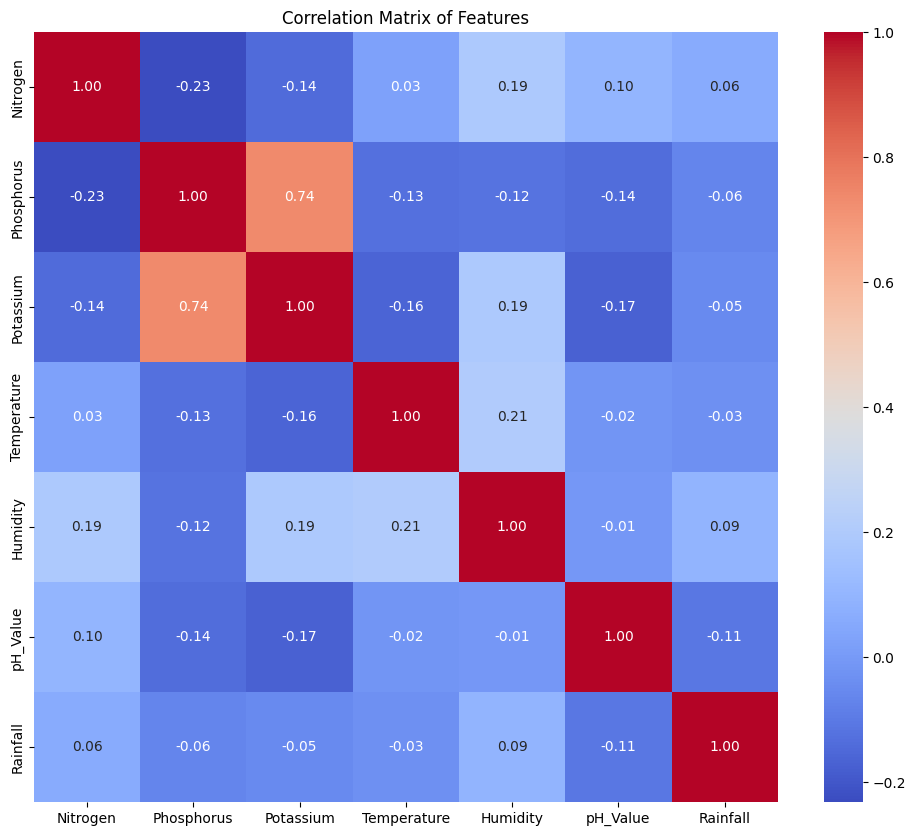

In [16]:
correlation_matrix = X.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [76]:
cols = ["Nitrogen", "Phosphorus", "Potassium", "Temperature", "Humidity", "pH_Value", "Rainfall"]
fig = px.box(X[cols], points="all")
fig.update_layout(title=dict(
        text="Range of Values for Features"
    ),
    xaxis=dict(
        title=dict(
            text="Features"
        )
    ),
    yaxis=dict(
        title=dict(
            text="Values"
        )
    ),)
fig.show()

In [30]:
# B: Outlier Detection
# Build statistical outlier detection function

# Separate dataset features for EDA
crops_features = X

def detect_outliers(dataset_features):
    """
    Detect outliers in the dataset using the Interquartile Range (IQR) method.

    Args:
        dataset_features (pd.DataFrame): Input DataFrame containing numerical features to analyze

    Returns:
        pd.DataFrame: DataFrame containing for each feature:
            - Lower Bound: Q1 - 1.5*IQR threshold for outliers
            - Upper Bound: Q3 + 1.5*IQR threshold for outliers
            - Outliers Count: Number of values outside the bounds
    Notes:
        - Uses the standard 1.5*IQR rule: points below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers
    """
    outliers = pd.DataFrame(index=crops_features.columns)
    # Calculate quantiles
    Q1 = dataset_features.quantile(0.25)
    Q3 = dataset_features.quantile(0.75)
    # Calculate IQR range
    IQR = Q3 - Q1
    # Define upper and lower bounds
    outliers['Lower Bound'] = Q1 - 1.5*IQR
    outliers['Upper Bound'] = Q3 + 1.5*IQR
    #
    outliers['Outliers Count'] = [
        ((dataset_features[col] < outliers.loc[col, 'Lower Bound']) |
         (dataset_features[col] > outliers.loc[col, 'Upper Bound'])).sum()
        for col in dataset_features.columns
    ]
    return outliers

# Print the result of detect_outliers
print("\nOutlier Analysis:")
print(detect_outliers(crops_features), '\n')


Outlier Analysis:
             Lower Bound  Upper Bound  Outliers Count
Nitrogen      -73.875000   179.125000               0
Phosphorus    -32.000000   128.000000             138
Potassium     -23.500000    92.500000             200
Temperature    14.080956    37.250073              86
Humidity       15.731726   134.478998              30
pH_Value        4.543768     8.351567              57
Rainfall      -25.022047   213.841241             100 



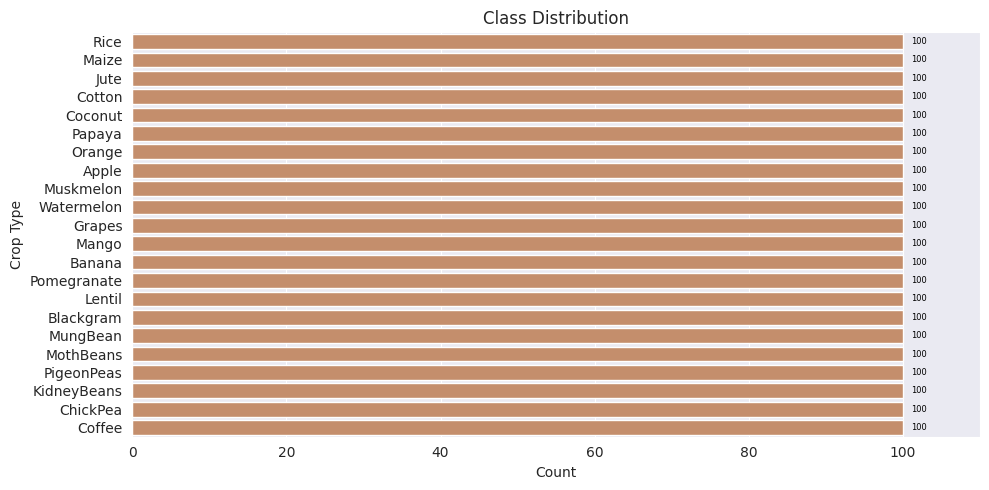

In [34]:
# A: Class Balance
# Visualize class distribution
class_dist = data['Crop'].value_counts()

fig, axes = plt.subplots(figsize=(10, 5))
sns.barplot(x=class_dist.values, y=class_dist.index, orient='h', color=custom_palette[3])

# Add value labels
for i, v in enumerate(class_dist.values):
    axes.text(v + 1, i, str(v), color='black', va='center', fontsize=6)

plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Crop Type')
plt.xlim(0, 110)  # Extend x-axis to make room for labels
plt.tight_layout()
plt.show()

In [35]:
# Create X featrures array
X = data.drop('Crop', axis=1)

# Creating Dummy Variables from Crop
le = LabelEncoder()
y = le.fit_transform(data['Crop'])  # Transform all crop values

# Split the already-transformed data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Dictionary for storing mean f1_scores, and f1_scores std
feature_performance = {}

# Dictionary for storing all scores instead of just mean and std
all_f1_scores = {}

# Create a list of feature names
features = (X.columns).to_list()

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate through each feature to evaluate its individual predictive power
for feature in features:
    # Define the preprocessing and model pipeline steps
    steps = [
        ('scaler', RobustScaler()), # Scale features using RobustScaler to handle outliers
        ('log_reg', LogisticRegression(
            penalty='l1',        # Use L1 (Lasso) regularization for feature selection
            solver='liblinear',  # Solver that supports L1 regularization (required)
            C=1.0,               # Regularization strength (1/lambda)
            max_iter=1000        # Set maximum iterations for convergence
        ))]

    # Create pipeline combining preprocessing and model
    pipeline = Pipeline(steps)

    # Calculate cross-validated F1 scores for each feature
    f1_scores = cross_val_score(pipeline, X_train[[feature]], y_train, cv=kf, scoring='f1_weighted')

    # Store mean and standard deviation of F1 scores
    feature_performance[feature] = {
        'avg_f1_score': f1_scores.mean(),
        'med_f1_score': np.median(f1_scores),
        'f1_std': f1_scores.std()
    }
    # Store all individual F1 scores for later visualization
    all_f1_scores[feature] = f1_scores

# Print Feature Performance Summary
print('Feature Performance Summary:')
for feature, metrics in sorted(feature_performance.items(), key=lambda x: x[1]['avg_f1_score'], reverse=True):
    print(f'\nFeature {feature}:')
    print(f'Avg F1 Score = {metrics["avg_f1_score"]:.4f} (±{metrics["f1_std"]:.4f})')
    print(f'Median F1 Score = {metrics["med_f1_score"]:.4f}')

Feature Performance Summary:

Feature Humidity:
Avg F1 Score = 0.1600 (±0.0250)
Median F1 Score = 0.1454

Feature Rainfall:
Avg F1 Score = 0.1595 (±0.0336)
Median F1 Score = 0.1504

Feature Potassium:
Avg F1 Score = 0.1300 (±0.0188)
Median F1 Score = 0.1398

Feature Phosphorus:
Avg F1 Score = 0.1004 (±0.0206)
Median F1 Score = 0.0993

Feature Nitrogen:
Avg F1 Score = 0.0619 (±0.0087)
Median F1 Score = 0.0649

Feature Temperature:
Avg F1 Score = 0.0539 (±0.0149)
Median F1 Score = 0.0639

Feature pH_Value:
Avg F1 Score = 0.0361 (±0.0063)
Median F1 Score = 0.0395


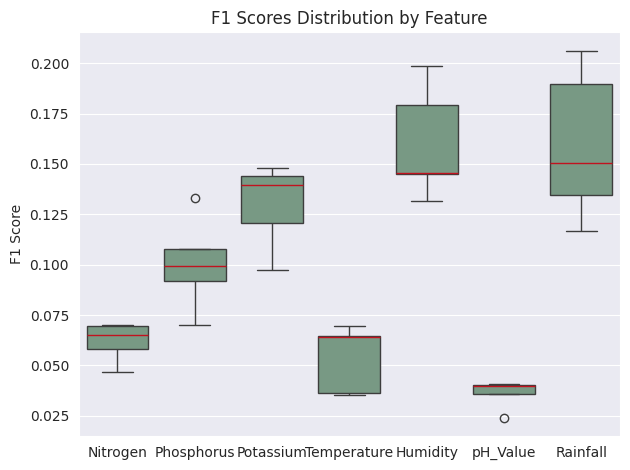

In [38]:
# Create the figure
fig, axes = plt.subplots()

# Create list of data in the correct format
f1_data = pd.DataFrame([all_f1_scores[feature] for feature in features]).T
# Add column names from features(from list of feature names)
f1_data.columns = features

# Create seaborn boxplot
sns.boxplot(data=f1_data, color=custom_palette[1], medianprops={'color': '#c1121f', 'linewidth': 1})

plt.title('F1 Scores Distribution by Feature')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

In [39]:
f1_data

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
0,0.070055,0.133086,0.144077,0.064463,0.198824,0.040741,0.189696
1,0.058318,0.107971,0.147949,0.036267,0.131616,0.035955,0.206262
2,0.064913,0.091740,0.120823,0.063893,0.179329,0.039497,0.134528
3,0.069379,0.070012,0.139763,0.069345,0.145399,0.023959,0.150435
4,0.046674,0.099348,0.097234,0.035361,0.144891,0.040400,0.116658


In [40]:
# Create pipeline for the final model
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),          # Scale features to handle outliers
    ('log_reg', LogisticRegression(
        penalty='l1',                     # L1 regularization for feature selection
        solver='liblinear',               # Required solver for L1
        C=1.0,                           # Regularization strength
        max_iter=1000                    # Maximum iterations to ensure convergence
    ))
])

# Train the model on full training dataset
final_pipeline.fit(X_train, y_train)

# Evaluate model performance
def evaluate_model(pipeline, X_train, y_train, X_test, y_test):
    """
    Evaluate model performance on both training and test sets.
    Check the model for over/underfitting.

    Args:
        pipeline: Trained model pipeline
        X_train, y_train: Training data
        X_test, y_test: Test data

    Returns:
        train_accuracy, test_accuracy, test_f1, y_pred
    """
    # Calculate training performance
    train_accuracy = pipeline.score(X_train, y_train)
    print('Training Metric')
    print(f'Training Accuracy: {train_accuracy*100:.2f}%')

    # Calculate test performance
    test_accuracy = pipeline.score(X_test, y_test)
    y_pred = pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print('\nTest Metrics')
    print(f'Test Accuracy: {test_accuracy*100:.2f}%')
    print(f'Test F1 Score: {test_f1*100:.2f}%')

    # Assess model fit
    print('\nModel Fit Analysis')
    if train_accuracy > test_accuracy + 0.05:
        print('Warning: Potential overfitting (>5% difference in accuracies)')
    elif train_accuracy < 0.6 and test_accuracy < 0.6:
        print('Warning: Potential underfitting (accuracies below 60%)')
    else:
        print('Good fit: Model shows balanced performance')

    return train_accuracy, test_accuracy, test_f1, y_pred

# Evaluate the final model
train_accuracy, test_accuracy, test_f1, y_pred = evaluate_model(
   final_pipeline, X_train, y_train, X_test, y_test
)

Training Metric
Training Accuracy: 96.99%

Test Metrics
Test Accuracy: 96.14%
Test F1 Score: 96.10%

Model Fit Analysis
Good fit: Model shows balanced performance


In [41]:
# Create predictions dataframe
predictions = X_test.copy()  # Copy test features
predictions['actual_crop'] = le.inverse_transform(y_test)     # Add actual values
predictions['predicted_crop'] = le.inverse_transform(y_pred)  # Add predicted values

# Show first 10 rows
predictions.head(10)

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,actual_crop,predicted_crop
1451,101,17,47,29.494014,94.729813,6.185053,26.308209,Muskmelon,Muskmelon
1334,98,8,51,26.179346,86.522581,6.259336,49.430510,Watermelon,Watermelon
1761,59,62,49,43.360515,93.351916,6.941497,114.778071,Papaya,Papaya
1735,44,60,55,34.280461,90.555616,6.825371,98.540477,Papaya,Papaya
1576,30,137,200,22.914300,90.704756,5.603413,118.604465,Apple,Apple
1110,18,19,27,27.755187,52.346058,4.772386,94.112133,Mango,Mango
1594,35,145,195,22.039115,94.580758,6.231950,110.980401,Apple,Apple
530,22,44,24,24.309351,56.329383,6.030447,58.995363,MothBeans,MothBeans
651,11,46,24,27.652802,89.806506,6.459252,56.525580,MungBean,MungBean
819,3,78,18,20.213682,68.652577,6.887130,50.897330,Lentil,Lentil


Text(0.5, 23.52222222222222, 'Predicted')

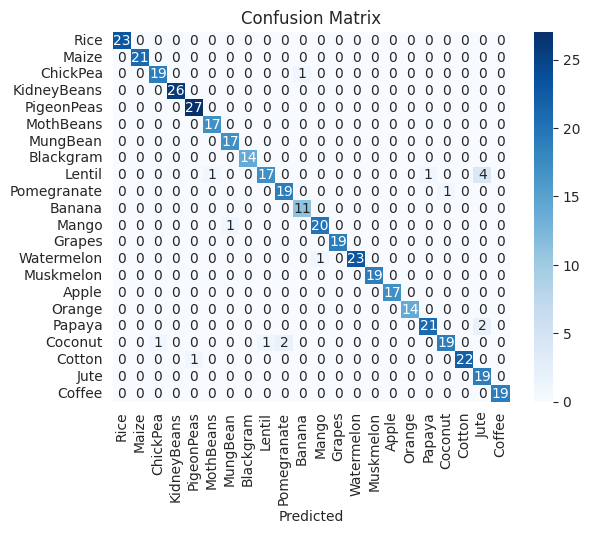

In [75]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(predictions['actual_crop'], predictions['predicted_crop'])
categories = list(data['Crop'].unique())
# Calculate group counts for each cell in confusion matrix
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]

# Create labels array with same shape as confusion_matrix
labels = np.asarray(group_counts).reshape(confusion_matrix.shape) # Reshape labels to match confusion matrix shape

sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')